# Prelude

In [1]:
# print code version (hash of checked out version)
print("\nCurrent commit:")
!git log -1
print("\nChanges since last commit:")
!git status --short

# print date and time of script execution
import datetime
print("\nNotebook executed at at {} in following directory:".format(datetime.datetime.now()))
%cd ..

# Enable interactive plots (%matplotlib -l to list backends)
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from common import analysis, units, morphology, treeutils
import models.GilliesWillshaw.gillies_pynn_model as gillies_model
import neuron; h = neuron.h
import bluepyopt.ephys as ephys

# Load custom synapse mechanisms
neuron.load_mechanisms('/home/luye/workspace/bgcellmodels/mechanisms/synapses')


Current commit:
commit 12ae3cc1b1de2b130f6566316991e38f0494e6db (HEAD -> nothreadsafe, origin/nothreadsafe)
Author: Lucas Koelman <lucas.koelman@gmail.com>
Date:   Mon May 21 20:03:44 2018 +0100

    Calibrate number & strength of STN afferent synapses

Changes since last commit:
 M ../../../README.md
 M calibrate_synapses_STN.ipynb
 M ../../KlmnNetMorpho/README.md

Notebook executed at at 2018-05-22 10:06:06.641382 in following directory:
/home/luye/workspace/bgcellmodels/models/GilliesWillshaw
	1 
	1 
 
loading STh cell data structures...
 
	1 
	1 
  2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
	1 


/home/luye/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


True

# Create cell

In [2]:
# ! EphysModelWrapper instantiates the cell in __init__()
cell = gillies_model.StnCellModel()
icell = cell.icell
nrnsim = cell.sim

In [3]:
named_seclists =  {listname: list(getattr(icell, listname)) for listname in cell.seclist_names}
for k, v in named_seclists.items():
    if len(v)==0:
        named_seclists.pop(k) # don't include empty SectionLists
    else:
        print("{} : {} sections".format(k, len(v)))

somatic = named_seclists['somatic']
dendritic = named_seclists['basal']

soma = somatic[0]
dend = dendritic[0]

nseg = sum((sec.nseg for sec in icell.all))
print("Total number of compartments: {}".format(nseg))

all : 35 sections
somatic : 1 sections
basal : 34 sections
Total number of compartments: 189


## Synapse Locations

A suitable compartment can be selected either using `treeutils.subtree_topology` or by using 
NEURON GUI -> Tools -> Distributed Mechanisms > Viewers > Shape Name

In [4]:
# inspect topology to determine good synapse location
# print(treeutils.subtree_topology(soma, max_depth=1))

# Pick segments on separate subtrees if you don't want simultaneous spikes to interfer
distal_seg = dendritic[8](0.75)
middle_seg = dendritic[20](0.25)
proximal_seg = dendritic[24](0.5)

<IPython.core.display.Javascript object>


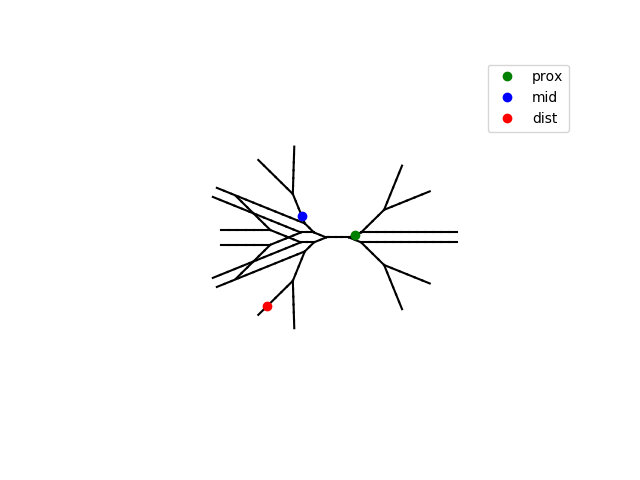

prox : SThcell[0].dend1[1]
mid : SThcell[0].dend0[20]
dist : SThcell[0].dend0[8]


In [5]:
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.view_init(90,90) # set azimut and elevation
ax.set_zlim((-1,1)) # prevent rounding errors
ax.set_axis_off() # hide x,y,z axes and grid

# Plot shape of our cell
h.define_shape(sec=soma) # for cells without 3D morphology
morphology.shapeplot(h, ax)

# Plot soma locations
markers = ('og', 'ob', 'or')
labels = ['prox', 'mid', 'dist']
for i, seg in enumerate((proximal_seg, middle_seg, distal_seg)):
    print(labels[i] + " : " + seg.sec.name())
    morphology.mark_locations(h, seg.sec, seg.x, label=labels[i], markspec=markers[i])

plt.legend()
plt.show()

# Excitatory Synapses

## Experimental Synapse Properties

For excitatory synapses (CTX -> STN), the paper by Chu (2015) about GP physiology shows AMPA and NMDA synapse properties in Figure 1.

**For AMPA**: Fig. 1E bottom left trace shows time course of an EPSC evoked when the cell is near its resting membrane potential:
- EPSC amplitude is ~ 275 pA
    + 275e-3 nA / (-80 mV - 0 mV) = -275e-3/80 uS = 3.44 nS
- time constant for rising phase (exponential) : ~ 1.0 ms
- time constant for decay phase (exponential) : ~ 4.0 ms


**For NMDA**: Fig. 1E top right trace shows time course of an EPSP evoked when the cell is at 40 mV which is close to the 30 mV at which Mg2+ block is removed from NMDAR.
- EPSC amplitude is ~ 210 pA
    + 210e-3 nA / (30 mV - 0 mV) = 210e-3 / 30 uS = 210/30 nS = 7 nS
- time constant for rising phase (exponential) : ~ 3.7 ms
- time constant for decay phase (exponential) : ~ 80.0 ms

Short term depression: time constant of 200 ms and base release probability of 0.7 fits data using Tsodyks-Markram model.
- TODO: find out which data, notes say Gradinaru 2009 but not found

## Results Summary (see below)

AMPA:
- Single synapse (no multi-synapse rule) with reported conductance of 3.44 nS yields plausible EPSP.

## Calibrate AMPA

In [ ]:
# Calibrate AMPA synapse to get desired PSP time course

spike_interval = 150.0
synapses, stims, netcons = [], [], []

conductance_nS = 3.44
tau_rise = 1.0
tau_decay = 4.0
tau_rec = 200.0
tau_facil = 1.0
P_release = 0.7

for i, seg in enumerate((proximal_seg, middle_seg, distal_seg)):
    syn = h.GLUsyn(seg)
    
    stim = h.NetStim()
    stim.number = 1
    stim.noise = 0
    stim.start = 750 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    #nc.weight[0] = conductance_nS / P_release # conductance in [nS]
    nc.weight[0] = 1.0
    syn.gmax_AMPA = conductance_nS / P_release * 1e-3 # [uS] or set netcon weight in [nS]
    syn.gmax_NMDA = 0.0
    syn.tau_r_AMPA = tau_rise
    syn.tau_d_AMPA = tau_decay
    
    syn.tau_rec = tau_rec
    syn.tau_facil = 1.0
    syn.U1 = P_release # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = -0.2 # 100 pA = 0.1 nA

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    'synGLU': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'V_prox': {'var':'v', 'seg':'prox'},
    'V_mid': {'var':'v', 'seg':'mid'},
    'V_dist': {'var':'v', 'seg':'dist'},
    # Synapse variables
    'gAMPA': {'pointp':'synGLU', 'var':'g_AMPA'},
    'gNMDA': {'pointp':'synGLU', 'var':'g_NMDA'},
    'iAMPA': {'pointp':'synGLU', 'var':'i_AMPA'},
    'iNMDA': {'pointp':'synGLU', 'var':'i_NMDA'},
    'iGLU': {'pointp':'synGLU', 'var':'i'},
    'Rrp': {'pointp':'synGLU', 'var':'R'},
    'Use': {'pointp':'synGLU', 'var':'Use'},
}

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.set_aCSF(4) # Hoc function defined in Gillies code
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

In [ ]:
# Plot recorded traces
plt.figure()
v_soma = vec_dict['V_soma'].as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

# Plot synaptic traces
fig, axes = plt.subplots(2,1)

ax = axes[0]
ax.plot(t_soma, vec_dict['gAMPA'].as_numpy(), 'b', label='gAMPA')
ax.plot(t_soma, vec_dict['gNMDA'].as_numpy(), 'r', label='gNMDA')
ax.set_ylabel('conductance (uS)')
ax.legend()

ax = axes[1]
ax.plot(t_soma, vec_dict['iAMPA'].as_numpy(), 'b', label='iAMPA')
ax.plot(t_soma, vec_dict['iNMDA'].as_numpy(), 'r', label='iNMDA')
ax.plot(t_soma, vec_dict['iGLU'].as_numpy(), 'g', label='i_tot')
ax.set_ylabel('current (nA)')
ax.legend()

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

## Calibrate NMDA

In [ ]:
# Calibrate NMDA synapse to get desired PSP time course
# NOTE: it is important to deliver spikes when Mg2+ gate is removed
#       e.g. by timing a pSP to arrive during a backpropagating spike
#       or after AMPA spikes

spike_interval = 150.0
synapses, stims, netcons = [], [], []

conductance_nS = 7.0
tau_rise = 3.7
tau_decay = 80.0
tau_rec = 200.0
tau_facil = 1.0
P_release = 0.7

for i, seg in enumerate((proximal_seg, middle_seg, distal_seg)):
    syn = h.GLUsyn(seg)
    
    stim = h.NetStim()
    stim.number = 1
    stim.noise = 0
    stim.start = 750 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    nc.weight[0] = conductance_nS / P_release # conductance in [nS]
    # syn.gmax_AMPA = 0.01 # [uS] or set netcon weight in [nS]
    syn.gmax_AMPA = 0.0
    syn.tau_r_NMDA = tau_rise
    syn.tau_d_NMDA = tau_decay
    
    syn.tau_rec = tau_rec
    syn.tau_facil = 1.0
    syn.U1 = P_release # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

# Disable spiking for more accurate PSP measurement
# for sec in h.allsec():
#     sec.gmax_NaF = 0.0

# Alternative to disable spiking: hyperpolarizing current (like in article figure)
istim = h.IClamp(soma(0.5))
istim.delay = 250
istim.dur = 1000
istim.amp = -0.2 # 100 pA = 0.1 nA

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'V_prox': {'var':'v', 'seg':'prox'},
    'V_mid': {'var':'v', 'seg':'mid'},
    'V_dist': {'var':'v', 'seg':'dist'},
}

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.set_aCSF(4) # Hoc function defined in Gillies code
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
v_soma = vec_dict['V_soma'].as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Inhibitory Synapse (GPe)

## Experimental Synapse Properties

For **GABA-A synapses** (GPe -> STN):

The paper by <span style='color:blue;font-weight:bold'> Chu (2015) </span> about GP physiology shows GABA-A ISPSc examples in Figures 2,3,4,5,6.

- IPSC amplitude is ~ 350 pA
    + 350e-3 nA / (-85 mV - -68 mV) = -350e-3/17 uS = 20.6 nS
- time constant for rising phase (exponential) : ~ 2.6 ms
- time constant for decay phase (exponential) : ~ 5.0 ms

The paper by <span style='color:blue;font-weight:bold'> Fan (2012) </span> shows GABA-A ISPSs and distribution of conductances in Fig. 2, and distributions of decay times in Fig. 1 (mISPC decay times should be same as for spike-induced IPSC).

- reported conductance is ~7 nS
    - median ~= 7 nS
    - sigma ~= 3 nS
- time constant for rising phase (exponential) : ~ 1.0 ms
- time constant for decay phase (exponential) : ~ 6.0 ms

The paper by <span style='color:blue;font-weight:bold'> Atherton (2013) </span> shows GABA-A IPSCs and short-term depression (STD) triggered by successive high-frequency IPSCs.

- exponential time constant of recovery is reported as 17.3 +/- 18.9 seconds
    - seee Fig 2B and legend
- time scale of depression:
    - Fig 2C-D: the x-axis means that the conductance distribution (min, mean, max) is for IPSCs falling between [i-1, i] seconds. So in the first second of 33 Hz stimulation the average amplitude is ~ 30% of peak amplitude, and in the second second it is ~ 12%.
    - example Fig. 1A, Fig 7A, 8A, 9A (control conditions)
- Fig 12 & 14 show magnitude of IPSPs for approx. 60 presynaptic inhibitory neurons foring synchronously
    - this indicates that indeed unitary conductances should be around 7 nS

For **GABA-B synapses** (GPe -> STN):

For inhibitory synapses (STR), the paper by Levine, Hull, Buchendwald (1974) about GP physiology shows following values in Figure 1:

- average IPSP trace shows approx. 5 mV dip from baseline
- exponential time constant for rising (dipping) phase : 66.0 ms
- exponential time constant for recovery phase : 100.0 ms

## Simulation Results

By cross-referencing and comparing data from three articles mentioned above, the conclusion is that the unitary conductance (single synapse) should approx. 7 nS as reported in Fan (2012). Hence for GABA-A we get:

- gsyn = 7 nS
- tau_rec = 17300.0
- tau_facil = 1.0
- P_release = 0.2


To calibrate a single GABAB synapse positioned at a proximal/trunk section, receiving volley of 8 spikes at 100 Hz to yield the IPSP shown in Figure 1, the following parameters work:

- gsyn = 0.0375 nS
- tau_rise_NT = 5.0 ms
- tau_decay_NT = 10.0 ms

In [ ]:
istim.amp = 0
istim = None

In [ ]:
# Calibrate GABAA conductance so we get PSP of desired magnitude

spike_interval = 150.0
synapses, stims, netcons = [], [], []

conductance_nS = 7.0
tau_rise = 2.0
tau_decay = 6.0
tau_rec = 17300.0
tau_facil = 1.0
P_release = 0.2

for i, seg in enumerate((proximal_seg,)):
    # Insert synapse in selected compartment
    syn = h.GABAsyn(seg)
    
    # Configure incoming spikes
    stim = h.NetStim()
    stim.number = 1e9 # need barrage to trigger signaling cascade
    stim_rate = 33.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 500 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    nc.weight[0] = conductance_nS / P_release # conductance in [nS]
    # syn.gmax_AMPA = 0.01 # [uS] or set netcon weight in [nS]
    syn.gmax_GABAB = 0.0
    syn.tau_r_GABAA = tau_rise
    syn.tau_d_GABAA = tau_decay
    
    syn.tau_rec = tau_rec
    syn.tau_facil = tau_facil
    syn.U1 = P_release # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    'synGABA': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'V_prox': {'var':'v', 'seg':'prox'},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAA'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.set_aCSF(4) # Hoc function defined in Gillies code
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
v_soma = vec_dict['V_soma'].as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

In [ ]:
# Calibrate GABAB conductance so we get PSP of desired magnitude

spike_interval = 0.0
synapses, stims, netcons = [], [], []

# NOTE: rise and decay time represent that of first quantity in signaling
#       cascade, NOT those of the conductance or IPSP
conductance_nS = 7.0
tau_rise = 5.0 # 66.0
tau_decay = 10.0 # 100.0

for i, seg in enumerate((proximal_seg,)):
    syn = h.GABAsyn(seg)
    
    stim = h.NetStim()
    stim.number = 8 # need barrage to trigger signaling cascade
    stim_rate = 100.0 # Hz
    stim.interval = stim_rate**-1*1e3
    stim.noise = 0
    stim.start = 500 + i*spike_interval
    
    nc = h.NetCon(stim, syn)
    nc.delay = 1.0
    
    # Synapse parameters
    hill_factor = 0.21
    nc.weight[0] = conductance_nS / hill_factor # conductance in [nS]
    # syn.gmax_AMPA = 0.01 # [uS] or set netcon weight in [nS]
    syn.gmax_GABAA = 0.0
    syn.tau_r_GABAB = tau_rise
    syn.tau_d_GABAB = tau_decay
    syn.U1 = 1.0 # release probability
    
    # Save refs
    synapses.append(syn)
    stims.append(stim)
    netcons.append(nc)

In [ ]:
# Define traces
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    'synGABA': synapses[0],
}

trace_specs = {
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'V_prox': {'var':'v', 'seg':'prox'},
    'gGABAA': {'pointp':'synGABA', 'var':'g_GABAB'},
    'Rrp': {'pointp':'synGABA', 'var':'Rrp'},
    'Use': {'pointp':'synGABA', 'var':'Use'},
}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.set_aCSF(4) # Hoc function defined in Gillies code
h.v_init = -68.0
h.tstop = 2000.0
h.init()
# h.run()
nrnsim.run(h.tstop, h.dt)

# Plot recorded traces
plt.figure()
v_soma = vec_dict['V_soma'].as_numpy()
t_soma = np.arange(len(v_soma)) * rec_dt
plt.plot(t_soma, v_soma)
plt.grid(True)

figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),

# Excitatory + Inhibitory synapses

The Observations Database contains following observations that may help in configuring the distribution of synapses on the STN dendritic tree:

## Afferents & Firing Rate

- each STN neuron receives approximately 300 synaptic inputs
    + each with mean conductance of 0.8 nS
    + (this indicates that the author is talking about one synaptic contact of a multi-synaptic connection)


- mean discharge rate of STN neurons 20-25 Hz
    + most STN neurons have a Poisson-like discharge rate with a slight tendency towards bursting

## GPe Synapse Information

- The majority of GP terminals innervate the proximal regions of STN neurons.
- one STN cells receives inputs from maximally 2% of GPe cells
- the strength of pallidal GABAergic synapses remains relatively constant along the dendritic tree of STN neurons.
- extrasynaptic GABAB receptors are closer to putative glutamatergic than putative GABAergic synapses in the STN.
- Unitary GABAAR-mediated GPe-STN conductances are large (~5-15 nS) because each axon forms multiple synaptic inputs with an individual postsynap-tic neuron
    + If we divide this 10 nS by the 0.8 nS mentioned above, we can infer that one afferent axon makes between 6-18 contacts. So if we represent each axon by a single simulated synapse, we can divide the 300 synapses by approx 12 and we get 24 synapses.


## CTX Synapse Information

- See parameters in calibration experiment above

## TODO

- set realistic cortical rate
- tweak until realistic conductances (see plots), balanced currents, and target rate approximated
- set fixed number of synapses on STN cells in network model, using same parameters

## Make GPe (GABA) Synapses

In [23]:
from common.protocols import pick_random_segments

rng_seed = 8
highest_indices = {rng_seed: 0} # max high_index for each low_index (seed)
stim_data = {}
rec_secs = {}


# Filter to select proximal, larger-diam dendritic segments
num_gpe_syn = 10

# see Gillies cell diagram
# can_have_synapse = lambda seg: seg.diam > 1.0
h.distance(0, 0.5, sec=soma)
can_have_synapse = lambda seg: h.distance(1, seg.x, sec=seg.sec) < 120.0
target_segs = pick_random_segments(dendritic, num_gpe_syn, can_have_synapse)

# Make synapses
for i_seg, target_seg in enumerate(target_segs):
    
    tstart = 300
    stim_rate = 50.0 # discharge rate in between pauses
    stim_interval = stim_rate**-1*1e3
    pause_dur = 300.0 # duration of pauses
    discharge_dur = 3000.0 # duration of firing in between pauses
    dur_max_ms = 10000.0
    

    # RNG settings
    num_indep_repicks = dur_max_ms / stim_interval + 1000
    low_index = rng_seed
    highest_index = highest_indices.get(low_index, 0)
    high_index = int(highest_index + num_indep_repicks)
    highest_indices[low_index] = high_index # update highest index

    # MCellRan4: each stream should be statistically independent as long as 
    # the highindex values differ by more than the eventual length of the stream.
    # See http://www.neuron.yale.edu/neuron/static/py_doc/programming/math/random.html?highlight=MCellRan4
    stimrand = h.Random() # see CNS2014 Dura-Bernal example or EPFL cell synapses.hoc file
    stimrand.MCellRan4(high_index, low_index)
    stimrand.negexp(1) # if num arrivals is poisson distributed, ISIs are negexp-distributed

    # make bursting NetStim
    stimsource = h.BurstStim()
    stimsource.fast_invl = stim_interval
    stimsource.slow_invl = pause_dur
    stimsource.burst_len = discharge_dur*1e-3*stim_rate
    stimsource.start = tstart
    stimsource.noise = 1.0
    stimsource.noiseFromRandom(stimrand) # Set it to use this random number generator
    
    
    # GABA Synapse
    syn = h.GABAsyn(target_seg)
    nc = h.NetCon(stimsource, syn)
    nc.delay = 1.0
    nc.weight[0] = 1.0
    
    # Synapse parameters
    tau_rise = 2.0
    tau_decay = 6.0
    tau_rec = 17300.0
    tau_facil = 1.0
    P_release = 0.2
    hill_factor = 0.35
    
    peak_factor = 250 # 1 / P_release
    syn.gmax_GABAA = 7.0 * peak_factor * 1e-3 # conductance in [nS]
    syn.tau_r_GABAA = 2.0
    syn.tau_d_GABAA = 6.0
    
    peak_factor = 1 / hill_factor
    syn.gmax_GABAB = 7.0 * peak_factor * 1e-3
    syn.tau_r_GABAB = 5.0
    syn.tau_d_GABAB = 10.0
    
    syn.tau_rec = tau_rec
    syn.tau_facil = tau_facil
    syn.U1 = P_release
    
    # Save inputs
    stim_data.setdefault('NetStims', []).append(stimsource)
    stim_data.setdefault('RNGs', []).append(stimrand)
    stim_data.setdefault('GABA_NetCons', []).append(nc)
    stim_data.setdefault('GABA_synapses', []).append(syn)

# Print values - sanity check
last_syn = stim_data['GABA_synapses'][-1]
for attr in 'gmax_GABAA', 'gmax_GABAB':
    print("{} :\t\t{}".format(attr, getattr(last_syn, attr)))

DEBUG@protocols.py:58>Found 32 eligible candidate segments
DEBUG@protocols.py:80>Picked 10 target segments.


gmax_GABAA :		1.75
gmax_GABAB :		0.02


## Make GLU (CTX) Synapses

In [24]:
# Filter to select proximal, larger-diam dendritic segments
num_syn = 14
can_have_synapse = lambda seg: seg.diam <= 1.0 # see Gillies cell diagram
target_segs = pick_random_segments(dendritic, num_syn, can_have_synapse)

rec_secs = {}
stim_data['GLU_NetCons'] = []
stim_data['GLU_synapses'] = []

# Make synapses
for i_seg, target_seg in enumerate(target_segs):
    
    tstart = 300
    stim_rate = 120.0 # discharge rate in between pauses
    stim_interval = stim_rate**-1*1e3
    discharge_dur = 30.0 # duration of firing in between pauses
    pause_dur = 100.0 - discharge_dur # duration of pauses -> bursts @ ~ 10 Hz
    dur_max_ms = 10000.0
    

    # RNG settings
    num_indep_repicks = dur_max_ms / stim_interval + 1000
    low_index = rng_seed
    highest_index = highest_indices.get(low_index, 0)
    high_index = int(highest_index + num_indep_repicks)
    highest_indices[low_index] = high_index # update highest index

    # MCellRan4: each stream should be statistically independent as long as 
    # the highindex values differ by more than the eventual length of the stream.
    # See http://www.neuron.yale.edu/neuron/static/py_doc/programming/math/random.html?highlight=MCellRan4
    stimrand = h.Random() # see CNS2014 Dura-Bernal example or EPFL cell synapses.hoc file
    stimrand.MCellRan4(high_index, low_index)
    stimrand.negexp(1) # if num arrivals is poisson distributed, ISIs are negexp-distributed

    # make bursting NetStim
    stimsource = h.BurstStim()
    stimsource.fast_invl = stim_interval
    stimsource.slow_invl = pause_dur
    stimsource.burst_len = discharge_dur*1e-3*stim_rate # ((1.0/pause_rate_hz) - pause_dur) * stim_rate
    assert stimsource.burst_len > 0
    
    stimsource.start = tstart
    stimsource.noise = 1.0
    stimsource.noiseFromRandom(stimrand) # Set it to use this random number generator
    
    # Make GLU synapse
    syn = h.GLUsyn(target_seg)
    nc = h.NetCon(stimsource, syn)
    nc.delay = 1.0
    nc.weight[0] = 1.0
    
    # Common Synapse parameters
    syn.tau_rec = 200.0
    syn.tau_facil = 800.0
    syn.U1 = P_release = 0.1 # release probability
    
    # AMPA synapse parameters
    conductance_nS = 3.44
    peak_factor = 4.0
    syn.gmax_AMPA = conductance_nS * peak_factor * 1e-3 # gmax is in [uS]
    syn.tau_r_AMPA = 1.0
    syn.tau_d_AMPA = 4.0
    
    # NMDA synapse parameters
    conductance_nS = 7.0 # 7 nS
    peak_factor = 2.0
    syn.gmax_NMDA = conductance_nS * peak_factor * 1e-3
    syn.tau_r_NMDA = 3.7
    syn.tau_d_NMDA = 80
    
    # Save inputs
    stim_data.setdefault('NetStims', []).append(stimsource)
    stim_data.setdefault('RNGs', []).append(stimrand)
    stim_data.setdefault('GLU_NetCons', []).append(nc)
    stim_data.setdefault('GLU_synapses', []).append(syn)

# Print values - sanity check
last_syn = stim_data['GLU_synapses'][-1]
for attr in 'gmax_AMPA', 'gmax_NMDA':
    print("{} :\t\t{}".format(attr, getattr(last_syn, attr)))

DEBUG@protocols.py:58>Found 168 eligible candidate segments
DEBUG@protocols.py:80>Picked 14 target segments.


gmax_AMPA :		0.01376
gmax_NMDA :		0.014


## Plot Synapse Locations

<IPython.core.display.Javascript object>


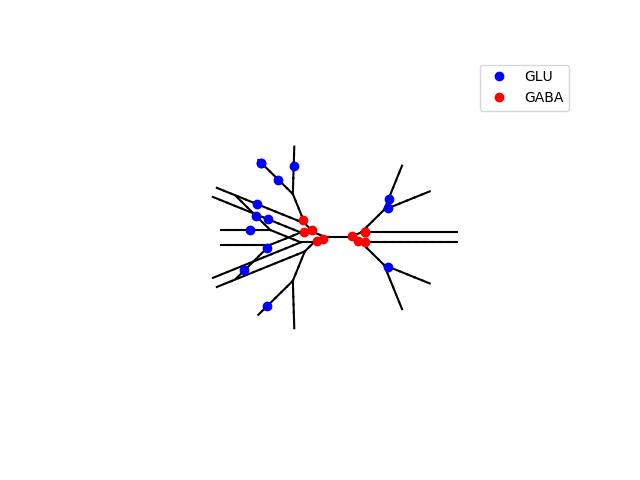

In [25]:
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.view_init(90,90) # set azimut and elevation
ax.set_zlim((-1,1)) # prevent rounding errors
ax.set_axis_off() # hide x,y,z axes and grid

# Plot shape of our cell
h.define_shape(sec=soma) # for cells without 3D morphology
morphology.shapeplot(h, ax)

# Plot synapse locations
for i, syn in enumerate(stim_data['GLU_synapses']):
    seg = syn.get_segment()
    label = 'GLU' if i==0 else None
    morphology.mark_locations(h, seg.sec, seg.x, label=label, markspec='ob')

for i, syn in enumerate(stim_data['GABA_synapses']):
    seg = syn.get_segment()
    label = 'GABA' if i==0 else None
    morphology.mark_locations(h, seg.sec, seg.x, label=label, markspec='or')

plt.legend()
plt.show()

## Record & Run

In [26]:
# Define traces
rec_secs = {
    'soma': soma,
    'soma_spiker': h.NetCon(soma(0.5)._ref_v, None, -10.0, 0, 0),
#     'prox': proximal_seg,
#     'mid': middle_seg,
#     'dist': distal_seg,
#     'synGABA': synapses[0],
}

trace_specs = {
    't_global': {'var': 't'},
    'V_soma': {'var':'v', 'sec':'soma', 'loc':0.5},
    'AP_soma': {'netcon': 'soma_spiker'},
    # Synapse variables
    'gAMPA': {'pointp':'synGLU0', 'var':'g_AMPA'},
    'gNMDA': {'pointp':'synGLU0', 'var':'g_NMDA'},
    'iAMPA': {'pointp':'synGLU0', 'var':'i_AMPA'},
    'iNMDA': {'pointp':'synGLU0', 'var':'i_NMDA'},
    'iGLU':  {'pointp':'synGLU0', 'var':'i'},
#     'Rrp': {'pointp':'synGLU', 'var':'R'},
#     'Use': {'pointp':'synGLU', 'var':'Use'},
    'gGABAA': {'pointp':'synGABA0', 'var':'g_GABAA'},
    'gGABAB': {'pointp':'synGABA0', 'var':'g_GABAB'},
    'iGABAA': {'pointp':'synGABA0', 'var':'i_GABAA'},
    'iGABAB': {'pointp':'synGABA0', 'var':'i_GABAB'},
    'iGABA':  {'pointp':'synGABA0', 'var':'i'},
}

# Record spikes at synapses
for i_syn, nc in enumerate(stim_data['GLU_NetCons']):
    con_label = "conGLU{}".format(i_syn)
    syn_label = "synGLU{}".format(i_syn)
    rec_secs[con_label] = nc
    rec_secs[syn_label] = nc.syn()
    trace_specs['AP_'+con_label] = {'netcon': con_label}
    trace_specs['i_'+syn_label] = {'pointp': syn_label, 'var':'i'}

for i_syn, nc in enumerate(stim_data['GABA_NetCons']):
    con_label = "conGABA{}".format(i_syn)
    syn_label = "synGABA{}".format(i_syn)
    rec_secs[con_label] = nc
    rec_secs[syn_label] = nc.syn()
    trace_specs['AP_'+con_label] = {'netcon': con_label}
    trace_specs['i_'+syn_label] = {'pointp': syn_label, 'var':'i'}

rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

In [27]:
# Init and run simulation
h.dt = 0.025
h.celsius = 35.0
h.set_aCSF(4) # Hoc function defined in Gillies code
h.v_init = -68.0
h.tstop = 5000.0
h.init()

import time
tstart = time.time()
nrnsim.run(h.tstop, h.dt)
tstop = time.time()
cputime = tstop - tstart
num_segments = sum((sec.nseg for sec in h.allsec()))
print("Simulated {} segments for {} ms in {} ms CPU time".format(
        num_segments, h.tstop, cputime))

Setting in vitro parameters based on Bevan & Wilson (1999)
Simulated 189 segments for 5000.0 ms in 73.0822901726 ms CPU time


## Plot Recordings

<IPython.core.display.Javascript object>


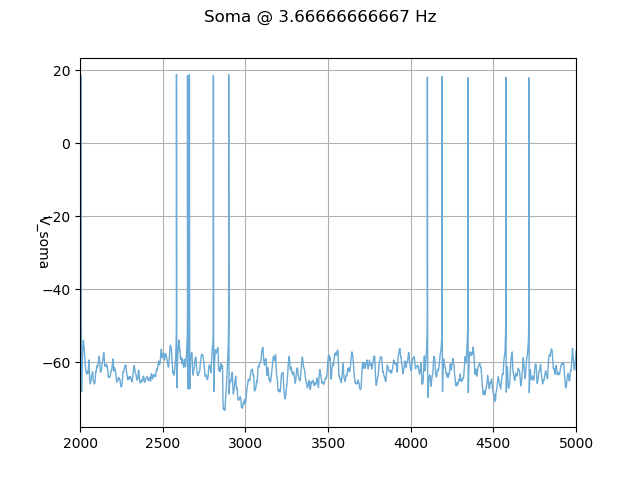

<IPython.core.display.Javascript object>


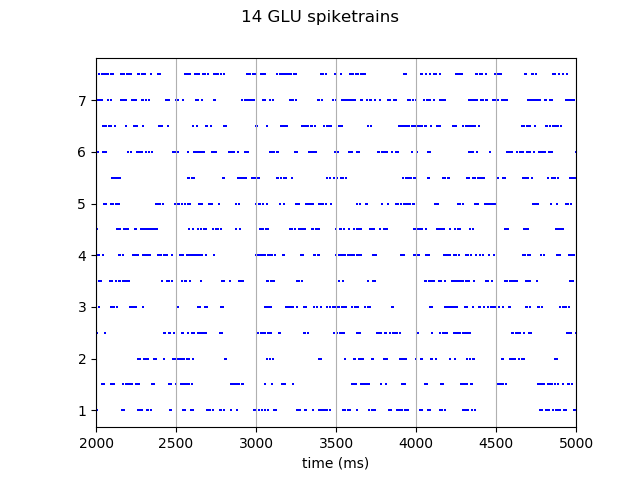

<IPython.core.display.Javascript object>


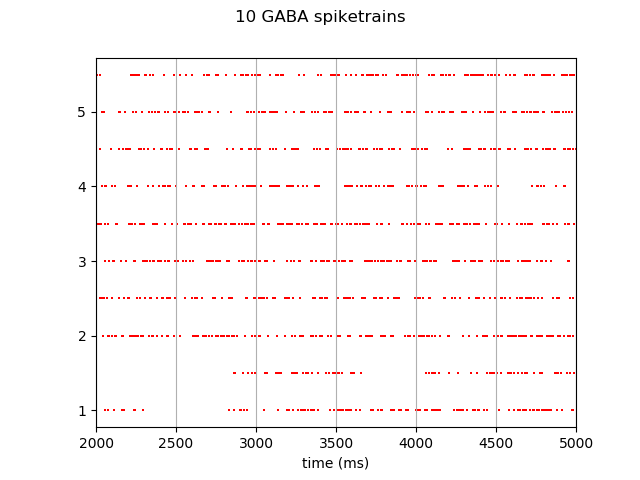

(<matplotlib.figure.Figure at 0x7fa92bb90850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa92bb71190>)

In [28]:
# Plot recorded traces
# t_global = vec_dict.pop('t_global').as_numpy() # inconsistent if dt != rec_dt 
interval = (2000, h.tstop)

# Plot somatic voltage traces
v_soma = vec_dict['V_soma'].as_numpy()
t_rec = np.arange(len(v_soma)) * rec_dt
# plt.figure()
# plt.plot(t_rec, v_soma)
# plt.grid(True)
spikes_soma = vec_dict['AP_soma'].as_numpy()
spike_range = (spikes_soma > interval[0]) & (spikes_soma <= interval[1])
soma_rate = len(spikes_soma[spike_range]) / float(interval[1]-interval[0]) * 1e3
analysis.plotTraces(vec_dict, rec_dt, interval, includeTraces=['V_soma'], title="Soma @ {} Hz".format(soma_rate))

# Plot spikes
spike_data = analysis.match_traces(vec_dict, lambda label: label.startswith('AP_conGLU'))
analysis.plotRaster(spike_data, interval, color='b', title='{} GLU spiketrains'.format(len(spike_data)))

spike_data = analysis.match_traces(vec_dict, lambda label: label.startswith('AP_conGABA'))
analysis.plotRaster(spike_data, interval, color='r', title='{} GABA spiketrains'.format(len(spike_data)))

<IPython.core.display.Javascript object>


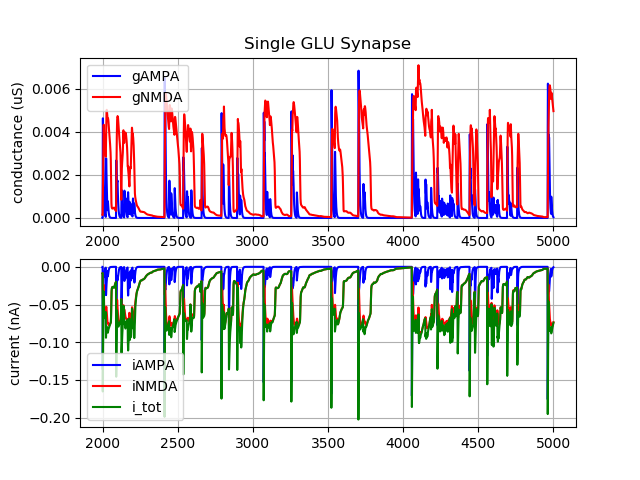

<IPython.core.display.Javascript object>


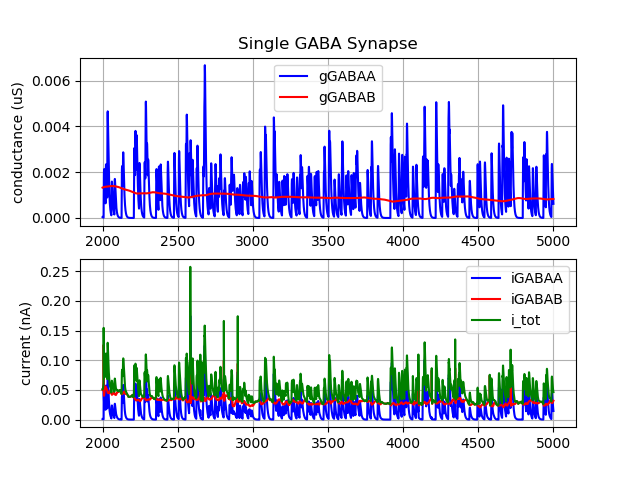

<IPython.core.display.Javascript object>


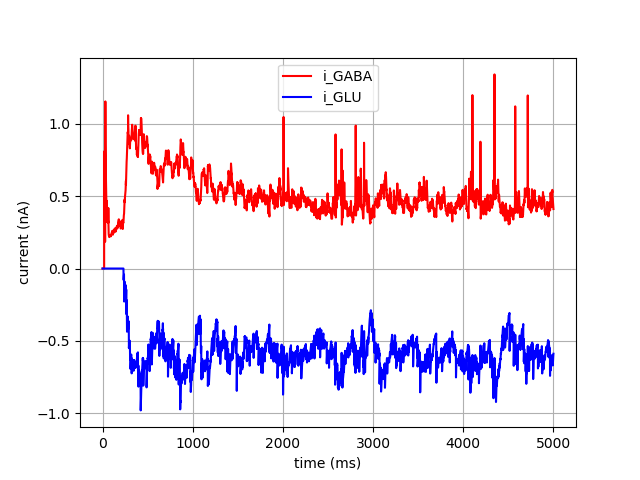

In [29]:
# Plot synaptic variables
a = int(interval[0] // rec_dt)
b = int(interval[1] // rec_dt)
t_plot = t_rec[a:b]

# Plot GLU synapse variables
fig, axes = plt.subplots(2,1)

ax = axes[0]
ax.plot(t_plot, vec_dict['gAMPA'].as_numpy()[a:b], 'b', label='gAMPA')
ax.plot(t_plot, vec_dict['gNMDA'].as_numpy()[a:b], 'r', label='gNMDA')
ax.set_ylabel('conductance (uS)')
ax.legend()
ax.grid(True)
ax.set_title('Single GLU Synapse')

ax = axes[1]
ax.plot(t_plot, vec_dict['iAMPA'].as_numpy()[a:b], 'b', label='iAMPA')
ax.plot(t_plot, vec_dict['iNMDA'].as_numpy()[a:b], 'r', label='iNMDA')
ax.plot(t_plot, vec_dict['iGLU'].as_numpy()[a:b], 'g', label='i_tot')
ax.set_ylabel('current (nA)')
ax.legend()
ax.grid(True)

# Plot GABA synapse variables
fig, axes = plt.subplots(2,1)

ax = axes[0]
ax.plot(t_plot, vec_dict['gGABAA'].as_numpy()[a:b], 'b', label='gGABAA')
ax.plot(t_plot, vec_dict['gGABAB'].as_numpy()[a:b], 'r', label='gGABAB')
ax.set_ylabel('conductance (uS)')
ax.legend()
ax.grid(True)
ax.set_title('Single GABA Synapse')

ax = axes[1]
ax.plot(t_plot, vec_dict['iGABAA'].as_numpy()[a:b], 'b', label='iGABAA')
ax.plot(t_plot, vec_dict['iGABAB'].as_numpy()[a:b], 'r', label='iGABAB')
ax.plot(t_plot, vec_dict['iGABA'].as_numpy()[a:b], 'g', label='i_tot')
ax.set_ylabel('current (nA)')
ax.grid(True)
ax.legend()

# Plot total GABA synapse current
itot_GABA = vec_dict['i_synGABA0'].as_numpy()
for i in range(1, len(stim_data['GABA_synapses'])):
    itot_GABA += vec_dict['i_synGABA{}'.format(i)].as_numpy()

itot_GLU = vec_dict['i_synGLU0'].as_numpy()
for i in range(1, len(stim_data['GLU_synapses'])):
    itot_GLU += vec_dict['i_synGLU{}'.format(i)].as_numpy()

plt.figure()
plt.plot(t_rec, itot_GABA, 'r', label='i_GABA')
plt.plot(t_rec, itot_GLU, 'b', label='i_GLU')
plt.ylabel('current (nA)')
plt.xlabel('time (ms)')
plt.legend()
plt.grid()
plt.show()
# Plot remaining traces
# figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True) # yRange=(-80,40),